[*********************100%***********************]  1 of 1 completed
2026-02-06 15:56:07.555003: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2026-02-06 15:56:07.555045: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2026-02-06 15:56:07.555055: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2026-02-06 15:56:07.555077: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2026-02-06 15:56:07.555090: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/rifai/.pyenv/versions/3.12.8/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do

Epoch 1/10


2026-02-06 15:56:08.419216: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0260
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0039
Epoch 3/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0031
Epoch 4/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0031
Epoch 5/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0027
Epoch 6/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0023
Epoch 7/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0024
Epoch 8/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0022
Epoch 9/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0021
Epoch 10/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0020
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Nilai Error (RMSE): 142.52 IDR


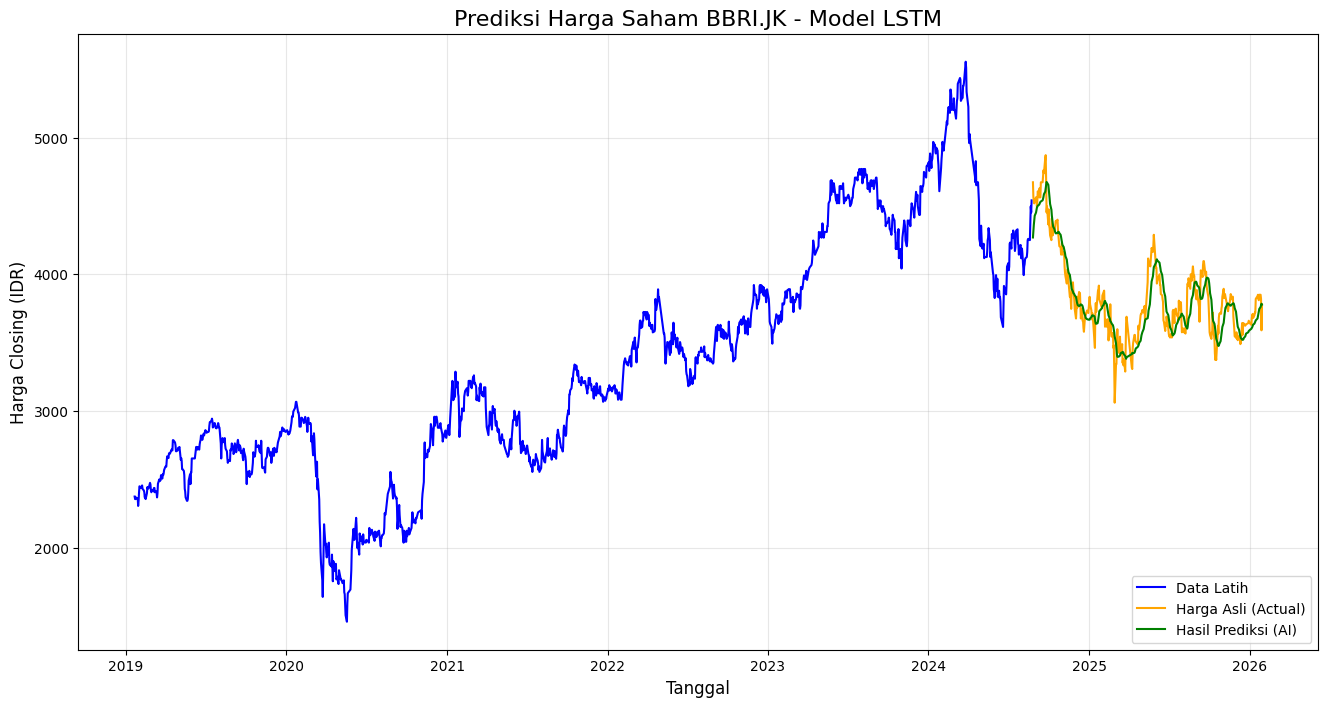

In [1]:
# =================================================================
# BAGIAN 1: DATA ACQUISITION (FIXED FOR MULTIINDEX)
# Narasi: "Program menarik data BBRI secara real-time..."
# =================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error

symbol = 'BBRI.JK'
# Menggunakan auto_adjust agar mendapatkan harga yang sudah disesuaikan
df = yf.download(symbol, start='2019-01-20', end='2026-01-30', auto_adjust=True)

# SOLUSI KEYERROR: Memaksa kolom menjadi satu tingkat (Flattening Columns)
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

# Mengambil data harga penutupan dan hapus baris kosong
data = df[['Close']].dropna()

# =================================================================
# BAGIAN 2: PREPROCESSING
# Narasi: "Normalisasi data ke skala 0-1..."
# =================================================================
dataset = data.values
training_data_len = int(np.ceil(len(dataset) * .8))

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60, len(scaled_data[:training_data_len])):
    x_train.append(scaled_data[i-60:i, 0])
    y_train.append(scaled_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# =================================================================
# BAGIAN 3: ARCHITECTURE (LSTM MODEL)
# Narasi: "Membangun otak AI dengan lapisan LSTM..."
# =================================================================

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=32, epochs=10, verbose=1)

# =================================================================
# BAGIAN 4: TESTING & PREDICTION
# =================================================================
test_data = scaled_data[training_data_len - 60: , :]
x_test = []
y_test = dataset[training_data_len:, :]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# =================================================================
# BAGIAN 5: ANALISIS HASIL AKHIR
# Narasi: "Visualisasi perbandingan prediksi vs harga pasar..."
# =================================================================
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Nilai Error (RMSE): {rmse:.2f} IDR")

train = data[:training_data_len]
valid = data[training_data_len:].copy()
valid.loc[:, 'Predictions'] = predictions # Menggunakan .loc untuk keamanan data

plt.figure(figsize=(16,8))
plt.title(f'Prediksi Harga Saham {symbol} - Model LSTM', fontsize=16)
plt.plot(train['Close'], color='blue', label='Data Latih')
plt.plot(valid['Close'], color='orange', label='Harga Asli (Actual)')
plt.plot(valid['Predictions'], color='green', label='Hasil Prediksi (AI)')
plt.xlabel('Tanggal', fontsize=12)
plt.ylabel('Harga Closing (IDR)', fontsize=12)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()